In [21]:
import argparse
import h5py
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import xml.etree.ElementTree as etree

In [22]:
from fastmri_prostate.reconstruction.t2.prostate_t2_recon import t2_reconstruction
from fastmri_prostate.reconstruction.dwi.prostate_dwi_recon import dwi_reconstruction
from fastmri_prostate.data.mri_data import load_file_T2, load_file_dwi, save_recon

In [23]:
fname_t2 = 'training_T2_1/file_prostate_AXT2_0001.h5'
fname_dwi = 'training_DIFFUSION_1/file_prostate_AXDIFF_0001.h5'

## T2

In [14]:
with h5py.File(fname_t2, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['calibration_data', 'ismrmrd_header', 'kspace', 'reconstruction_rss']>


In [16]:
kspace_t2, calibration_data_t2, hdr_t2, image_recon, image_atts = load_file_T2(fname_t2)

In [17]:
kspace_t2.shape, calibration_data_t2.shape

((3, 30, 20, 640, 451), (30, 20, 640, 32))

In [24]:
image_recon.shape

(30, 320, 320)

In [25]:
def display_t2_slice(img, slice_num):
    plt.imshow(img[slice_num, :, :] ,cmap='gray')

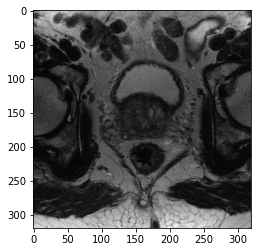

In [26]:
display_t2_slice(image_recon, 10)

## DWI

In [39]:
kspace_dwi, calibration_data_dwi, coil_sens_maps, hdr_dwi = load_file_dwi(fname_dwi)

In [40]:
kspace_dwi.shape, calibration_data_dwi.shape

((50, 30, 20, 200, 150), (30, 20, 200, 32))

In [41]:
with h5py.File(fname_dwi, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['adc_map', 'b1000x', 'b1000y', 'b1000z', 'b1500', 'b50x', 'b50y', 'b50z', 'calibration_data', 'coil_sens_maps', 'ismrmrd_header', 'kspace', 'phase_correction', 'trace_b1000', 'trace_b50']>


In [42]:
dwi_recons = {}

sources = [
    'b50x', 'b50y', 'b50z', 
    'b1000x', 'b1000y', 'b1000z',
    'trace_b50', 'trace_b1000', 'adc_map', 'b1500'
]

with h5py.File(fname_dwi, 'r') as f:
    for s in sources:
        dwi_recons[s] = f[s][:]

In [51]:
for k, v in dwi_recons.items():
    print(k, v.shape)

b50x (30, 100, 100)
b50y (30, 100, 100)
b50z (30, 100, 100)
b1000x (30, 100, 100)
b1000y (30, 100, 100)
b1000z (30, 100, 100)
trace_b50 (30, 100, 100)
trace_b1000 (30, 100, 100)
adc_map (30, 100, 100)
b1500 (30, 100, 100)


In [68]:
def display_dwi_slice(dwi_recons, slice_num):
    _, ax = plt.subplots(2, 5, figsize=(14,14))
    
    for idx, k in enumerate(['b50x', 'b50y', 'b50z', 'trace_b50', 'adc_map']):
        ax[0][idx].imshow(dwi_recons[k][slice_num, :, :], cmap='gray')
        ax[0][idx].title.set_text(k)
    
    for idx, k in enumerate(['b1000x', 'b1000y', 'b1000z', 'trace_b1000', 'b1500']):
        ax[1][idx].imshow(dwi_recons[k][slice_num, :, :], cmap='gray')
        ax[1][idx].title.set_text(k)

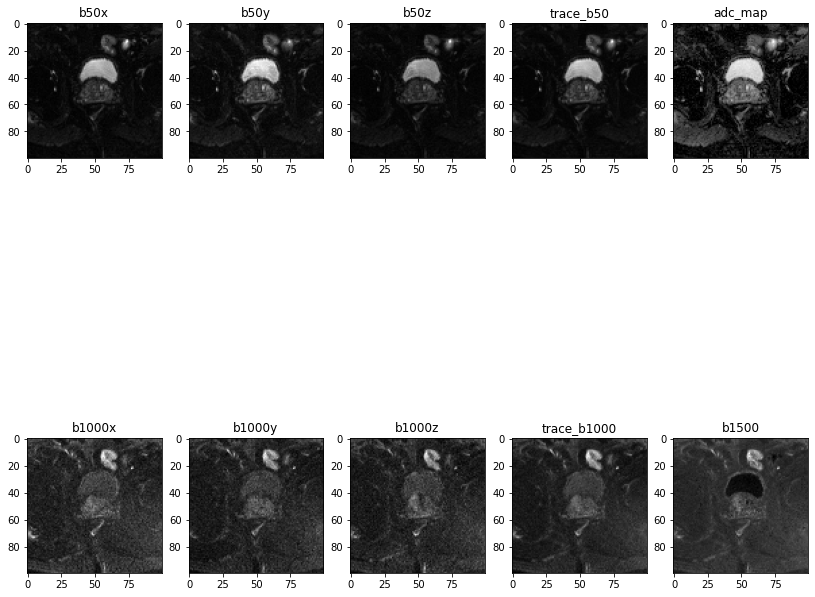

In [69]:
display_dwi_slice(dwi_recons, 10)